# Train models MDF dataset

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.utils import plot_model
from keras.models import Sequential
from keras.layers import Dense, Input, Embedding, Flatten, Concatenate, Lambda
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.model_selection import GridSearchCV, KFold
import rs_models
import implicit
from scipy.sparse import coo_matrix, csr_matrix
from matplotlib import pyplot as plt
import math
from tqdm import tqdm

from implicit.evaluation import AUC_at_k, precision_at_k, train_test_split
from implicit.als import AlternatingLeastSquares

pd.options.display.max_columns = 1000
import warnings
warnings.filterwarnings("ignore")

## Load dataset

In [ ]:
df = pd.read_csv('Datasets/MDF_final.csv')
df = df.drop_duplicates()
df.user = pd.factorize(df.user)[0] # make sure that user and item IDs start from zero
df.item = pd.factorize(df.item)[0]
df.reset_index(drop=True, inplace=True)
# df = df.drop(['place_type_food_and_drink', 'place_type_health', 'place_type_home', 'place_type_lodging','place_type_outdoors', 'place_type_point_of_interest_establishment','place_type_public_transport_station', 'place_type_school','place_type_service', 'place_type_store', 'place_type_workplace'], axis = 1)

item_labels = [i for i in list(df.columns) if i.find("category") == 0] # labels that describe an item
context_labels = list(set(df.iloc[:, 3:]) - set(item_labels)) # takes all the columns after user, item rating and remove item labels

n_users = df.user.nunique()
n_items = df.item.nunique()
n_contexts = len(context_labels)

print(f"rating with value 1: {df[df.rating == 1]['rating'].count() * 100 / len(df)} %")
print(f"users: {n_users} \t items: {n_items} \t rating: {len(df)} \t items_features: {len(item_labels)} \t contexts_features: {n_contexts} \t ")

In [ ]:
n_splits = 10
models_eval_metrics = {}

## ALS matrix factorization
- Precision@k = (# of recommended items @k that are relevant) / (# of recommended items @k)

In [89]:
df_mf = pd.read_csv('Datasets/MDF_matrix_factorization.csv')
K=[1, 5, 10, 20]
mf_results = rs_models.train_mf(df_mf, factors=256, regularization=7, iterations=200, n_splits=n_splits, K=K)
for auc, precision, k in zip(mf_results['AUC'], mf_results['precision'], K):
    print(f'AUC@{k}: {auc} \t Precision@{k}: {precision}')

AUC@1: 0.5606253641953969 	 Precision@1: 0.6371510673234811
AUC@5: 0.6824152517461004 	 Precision@5: 0.4771878430194074
AUC@10: 0.7177480670672827 	 Precision@10: 0.4279449782833156
AUC@20: 0.753071213198948 	 Precision@20: 0.49080292733857983


$$
Accuracy = \frac{\text{Number of correct predictions}}{\text{Total number of predictions}} = \frac{TP+TN}{TP+TN+FP+FN}
$$

$$
Precision = \frac{TP}{TP+FP}
$$

A model that produces no false positives has a precision of 1.0

$$
Recall = \frac{TP}{TP+FN}
$$

A model that produces no false negatives has a recall of 1.0

## NeuMF

In [ ]:
param = {
    'n_users': n_users,
    'n_items': n_items,
    'n_contexts': n_contexts,
    'learn_rate': 0.001,
    'batch_size': 64,
    'epochs': 10
}   


std_dev, accuracy, auc, precision, recall = rs_models.kfold_train(rs_models.NeuMF, param, df, n_splits=n_splits)
models_eval_metrics['NeuMF'] = [accuracy, auc, precision, recall]
print(f"NeuMF \t accuracy: {accuracy*100}% \t AUC: {auc} \t precision: {precision} \t recall: {recall}")

## ECAM NeuMF

In [ ]:
param = {
    'n_users': n_users,
    'n_items': n_items,
    'n_contexts': n_contexts,
    'learn_rate': 0.001,
    'batch_size': 256,
    'epochs': 10
}  

std_dev, accuracy, auc, precision, recall = rs_models.kfold_train(rs_models.ECAM_NeuMF, param, df, context_labels=context_labels, n_splits=n_splits)
models_eval_metrics['ECAM NeuMF'] = [accuracy, auc, precision, recall]
print(f"ECAM NeuMF \t accuracy: {accuracy*100}% \t AUC: {auc} \t precision: {precision} \t recall: {recall}")

## Classifier

In [ ]:
from sklearn.model_selection import cross_validate

ffnet = KerasClassifier(build_fn=rs_models.mobile_model, neurons=100, layers=3, learn_rate=0.005, epochs=10, batch_size=64, verbose=False)
x = df[item_labels+context_labels]
y = df['rating']

scores = cross_validate(ffnet, x, y, cv=KFold(shuffle=True, n_splits=n_splits, random_state=42), scoring=['accuracy', 'roc_auc', 'precision', 'recall'])

accuracy = np.average(scores['test_accuracy'])
auc = np.average(scores['test_roc_auc'])
precision = np.average(scores['test_precision'])
recall = np.average(scores['test_recall'])
models_eval_metrics['Classifier'] = [accuracy, auc, precision, recall]

print(f"Classifier \t accuracy: {accuracy*100}% \t AUC: {auc} \t precision: {precision} \t recall: {recall}")

## Plot Results

In [ ]:
n_models = len(models_eval_metrics) # number of different models
models_name = [x[0] for x in models_eval_metrics.items()] 

accuracy = [x[0] for x in models_eval_metrics.values()]
auc = [x[1] for x in models_eval_metrics.values()]
precision = [x[2] for x in models_eval_metrics.values()]
recall = [x[3] for x in models_eval_metrics.values()]

index = np.arange(n_models)
bar_width = 0.15
plt.figure(figsize=(10,6))

# accuracy bar
rect1 = plt.bar(index, accuracy, bar_width, color='#ff7b00', label='Accuracy')

# AUC bar
rect2 = plt.bar(index + bar_width, auc, bar_width, color='b', label='AUC')

# precision bar
rect3 = plt.bar(index + bar_width*2, precision, bar_width, color='g', label='Precision')

# recall bar
rect4 = plt.bar(index + bar_width*3, recall, bar_width, color='r', label='Recall')

plt.style.use("fivethirtyeight")
plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Prediction results')
plt.xticks(index + bar_width * 3/2, models_name) # labels position
plt.legend(bbox_to_anchor=(1.3, 1))
plt.grid(True)
plt.savefig('prediction_results.png')
plt.show()

for key, item in models_eval_metrics.items():
    print(f'Model: {key} Accuracy: {item[0]*100}% AUC: {item[1]} Precision: {item[2]} Recall: {item[3]}')

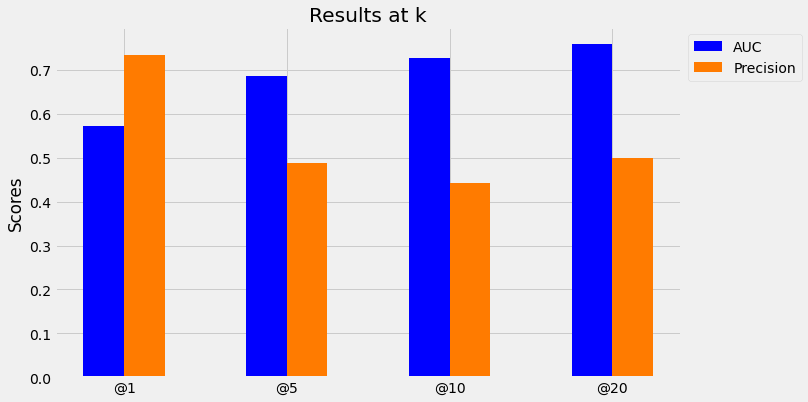

In [84]:
index = np.arange(4)
bar_width = 0.25

plt.figure(figsize=(10,6))

plt.bar(index, mf_results['AUC'], bar_width, color='blue', label='AUC')
plt.bar(index+bar_width, mf_results['precision'], bar_width, color='#ff7b00', label='Precision')

plt.style.use("fivethirtyeight")
plt.ylabel('Scores')
plt.title('Results at k')
plt.xticks(index + bar_width/2, ['@1', '@5', '@10', '@20']) # labels position
plt.legend(bbox_to_anchor=(1, 1))
plt.grid(True)
plt.savefig('prediction_results.png')
plt.show()